In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline

if False:
    # Paths for Laika
    physDataDir = '/home/svadarevu/gitwork/linear/data/'
    covDataDir = '/home/svadarevu/gitwork/linear/cov/'
    specDataDir = '/kepler/sabarish/data/r590/FF/'
    libDir = '/home/svadarevu/gitwork/linear/library/'
    #sys.path.append('/home/svadarevu/gitwork/linear/library/')
else:
    physDataDir = '/media/sabarish/channelData/R590/phys/'
    specDataDir = '/media/sabarish/channelData/R590/spec/'
    covDataDir =  '/media/sabarish/channelData/R590/cov/'

# Testing CC_AMA code

In [ ]:
os.chdir(libDir)
%run test_minimize.py
#os.chdir(specDataDir)

# Testing the Schur decomposition thingy
## $ Z = BH^* + HB^*$

In [ ]:
# The decomposition should work for any Hermitian matrix,
Z = np.random.randn(21,21) + 1.j*np.random.randn(21,21)
Z = Z + Z.conj().T

B,H,S = ops.decomposeZ(Z)
print("Error in the decomposition for some random Hermitian matrix is,",
np.linalg.norm(
    Z - 
    (B @ H.conj().T + H @ B.conj().T),
    ord=2) )

# Convergence for Re=186
## Successive averages of U for 5 flow-throughs each

In [ ]:
avgDir = '/media/sabarish/channelData/R186/avg/'
Uarr = np.zeros((20,192))
for n in range(20):
    for ti in range(100):
        t = (100*n + ti)*50+50000
        fName = avgDir + 'u_avg_it%d.dat'%t
        with open(fName,'r') as inFile:
            Uarr[n] = Uarr[n] + np.loadtxt(inFile, dtype=np.float64)[3:-3]
Uarr = Uarr/100.

In [ ]:
z = pseudo.chebdif(194,1)[0][1:-1]
for n in range(10,20):
    plt.plot(z, (Uarr[n] - Uarr[-1])/Uarr[-1])
plt.show()

plt.figure()
for n in range(14):
    plt.plot(z, Uarr[n])
plt.show()


## Linear shear stress profile
For stationary turbulent channel flow, the mean and fluctuating velocities must go as
$\frac{dU^+}{dz^+} - \big< u'w'\big> ^+ \approx 1- \frac{z'}{h} $

Note: This $z'$ goes from 0 to $h$ only, and not $-h$ to $h$. 

In [ ]:
# Plotting the residual in the shear stress for the last 50 flow through times,
#   10 flow-throughs at a time
# Each flow-through corresponds to an n_timeSteps = 1000
# I save fields at every 50 timeSteps, so average over every 200 files
# Let's start from the last snapshot
meanFilePrefix = os.environ['DATA186']+'avg/u_avg_it'
rssFilePrefix = os.environ['DATA186']+'avg/wu_corr_it'

UArr = np.zeros((5,192))
UzArr = UArr.copy()
rssArr = np.zeros((5,192))
z,D = pseudo.chebdif(194,1)
z = z[1:-1]; D = D[1:-1,1:-1]
D = D.reshape((192,192))

for n in range(5):
    for ti in range(200):
        t = 150000 - (200*n+ti)*50
        mfName = meanFilePrefix + '%d.dat'%t
        rssfName = rssFilePrefix + '%d.dat'%t
        with open(mfName,'r') as inFile:
            U = np.loadtxt(inFile, dtype=np.float)
        with open(rssfName,'r') as inFile:
            rss = np.loadtxt(inFile, dtype=np.float)
        UArr[n] = UArr[n] + U[3:-3]
        #print('UCL=',U[99])
        rssArr[n] = rssArr[n] + rss[3:-3]
    print(UArr[n,99])
    UzArr[n] = D @ UArr[n]

UArr = UArr/200.
rssArr = rssArr/200.
UzArr = UzArr/200.
    
    
print(UArr[:,99])        

In [ ]:
ztmp = np.loadtxt(os.environ['DATA186']+'avg/zp.dat',dtype=np.float)
UDNS = np.zeros(194)   # Including nodes at the walls
zDNS = np.zeros(194)
rssDNS = np.zeros(194)
UDNS[1:-1] = UArr[-1]
rssDNS[1:-1] = rssArr[-1]
zDNS[1:-1] = ztmp[3:-3]
zDNS[-1] = 2.
########
nInd = 1
UDNS[:nInd] = zDNS[:nInd]
UDNS[-nInd:] = UDNS[nInd-1::-1]

###########


Ufun = interp1d(zDNS,UDNS,kind='cubic')
rssfun = interp1d(zDNS,rssDNS,kind='cubic')
z,D = pseudo.chebdif(194,1)
z = 1. - z[1:-1]
#z = 1.-z
D = D[1:-1,1:-1,0]
#D = D[:,:,0]
U = Ufun(z)

########
nInd = 0
U[:nInd] = z[:nInd]
U[-nInd:] = U[nInd-1::-1]

###########

rss = rssfun(z)
Uz = D @ U

residual = -Uz/186. - rss

plt.plot(z, residual)
plt.show()

# Testing finite differences for DNS

In [ ]:
zDNS = np.loadtxt(os.environ['DATA186']+'avg/zp.dat',dtype=np.float)
nz = 192
indArr = np.arange(nz)
# Defining cells: 
ztmp1 = np.cos(np.pi * indArr/nz)   # Top edge of internal cell, cos(n*pi/N) for n=0 to N-1
ztmp2 = np.cos(np.pi * (indArr+1)/nz)   # Bottom edge of internal cell, cos(n*pi/N) for n=1 to N
zCC = 0.5*(ztmp1 + ztmp2)
dz = ztmp1 - ztmp2
plt.plot(zCC, (1.-zDNS[3:-3])-zCC)
plt.show()
zDNS[3:-3] = 1.-zCC
#zDNS[:98:-1] = 2. - zDNS[:99]

Utest = (1. - (1. - zDNS)**2 )
#Utest = np.loadtxt(os.environ['DATA186']+'avg/u_avg_it150000.dat',dtype=np.float)
Utest[2::-1] = -Utest[3:6]
Utest[:194:-1] = -Utest[192:195] 
d2Utest = miscUtil.DNSderivs(Utest)
if False:
    plt.semilogx(186*zDNS[3:], Utest[3:],'x-')
    plt.xlim([0.,150.])
    plt.show()

print("Velocity profile is 1-z^2, whose second derivative is -2")
print("This plot shows that there are no weird scaling factors showing up")
plt.figure()
plt.semilogx(186*zDNS[3:-3], d2Utest[:],'x-')
plt.xlim([0.,150.])
#plt.ylim([-3000.,0.])
plt.ylim([-1.9,-2.1])
plt.show()

print("Repeating for (1-z^2)^2, whose second derivative is -4+12z^2")
Utest = (1. - (1. - zDNS)**2 )**2
Utest = 0.5*(Utest + Utest[::-1])
#Utest = np.loadtxt(os.environ['DATA186']+'avg/u_avg_it150000.dat',dtype=np.float)
#Utest[2::-1] = -Utest[3:6]
#Utest[:194:-1] = -Utest[192:195] 
d2Utest = miscUtil.DNSderivs(Utest)
if False:
    plt.semilogx(186*zDNS[3:], Utest[3:],'x-')
    plt.xlim([0.,150.])
    plt.show()

d2f = -4. + 12.*(1.-zDNS[3:-3])**2
plt.figure()
plt.plot(zDNS[6:-6], (d2Utest[3:-3]-d2f[3:-3]), 'rx-')
plt.title('Error in second derivative')
plt.show()

print("Relative error is ~ 10^-3")
plt.figure()
plt.plot(zDNS[6:-6], d2Utest[3:-3], zDNS[6:-6],d2f[3:-3])
plt.title('Analytical value for second derivative')
plt.show()

print("Repeating for (1-z^2)^4, whose second derivative is -6 + 36z^2 -30z^4")
Utest = (1. - (1. - zDNS)**2 )**4
Utest = 0.5*(Utest + Utest[::-1])
#Utest = np.loadtxt(os.environ['DATA186']+'avg/u_avg_it150000.dat',dtype=np.float)
#Utest[2::-1] = -Utest[3:6]
#Utest[:194:-1] = -Utest[192:195] 
d2Utest = miscUtil.DNSderivs(Utest)
if False:
    plt.semilogx(186*zDNS[3:], Utest[3:],'x-')
    plt.xlim([0.,150.])
    plt.show()

d2f = -6. + 36.*(1.-zDNS[3:-3])**2 - 30.*(1.-zDNS[3:-3])**4
plt.figure()
plt.plot(zDNS[6:-6], (d2Utest[3:-3]-d2f[3:-3]), 'rx-')
plt.title('Error in second derivative')
plt.show()

print("Relative error is ~ 10^-3")
plt.figure()
plt.plot(zDNS[6:-6], d2Utest[3:-3], zDNS[6:-6],d2f[3:-3])
plt.title('Analytical value for second derivative')
plt.show()



In [ ]:
plt.semilogy(zDNS, np.abs(Utest - Utest[::-1]))
plt.semilogy(zDNS[3:-3], np.abs(d2Utest - d2Utest[::-1]))
#plt.semilogy(zDNS, np.abs(Utest - Utest[::-1]))
plt.show()

Mean velocity from a DNS snapshot


/home/sabarish/Dropbox/melb/code/library/miscUtil.py:169: UserWarning: Ensure that the inputs, U and z, include 3 ghost cells along wall-normal on either side
  warn('Ensure that the inputs, U and z, include 3 ghost cells along wall-normal on either side')
/home/sabarish/Dropbox/melb/code/library/miscUtil.py:170: UserWarning: Test this function with simple cubic profile on z
  warn("Test this function with simple cubic profile on z")


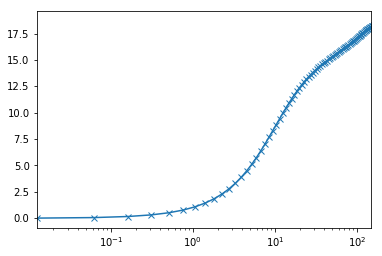

This plot shows that, for U from DNS, the derivative is smooth


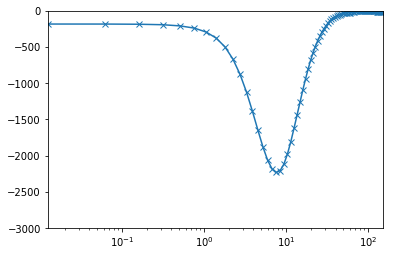

In [5]:
print("Mean velocity from a DNS snapshot")
zDNS = np.loadtxt(os.environ['DATA186']+'avg/zp.dat',dtype=np.float)
#Utest = (1. - (1. - zDNS)**2 )
Utest = np.loadtxt(os.environ['DATA186']+'avg/u_avg_it150000.dat',dtype=np.float)
#Utest[2::-1] = -Utest[3:6]
#Utest[:194:-1] = -Utest[192:195] 
d2Utest = miscUtil.DNSderivs(Utest)
plt.semilogx(186*zDNS[3:], Utest[3:],'x-')
plt.xlim([0.,150.])
plt.show()

print("This plot shows that, for U from DNS, the derivative is smooth")
plt.figure()
plt.semilogx(186*zDNS[3:-3], d2Utest[:],'x-')
plt.xlim([0.,150.])
plt.ylim([-3000.,0.])
#plt.ylim([-3.,3.])
plt.show()

## Analytical U profile for turbulent channel

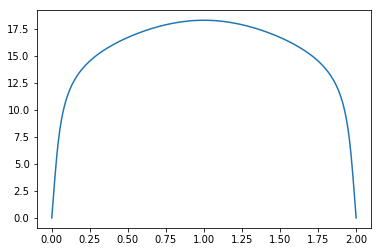

In [8]:
from scipy.integrate import quad
a = 25.4
k = 0.426
Re = 186.
nuT = lambda zt: -0.5 + 0.5*np.sqrt( 1.+
    (k*Re/3.* (2.*zt - zt**2) * (3. - 4.*zt + 2.*zt**2) *
         (1. - np.exp( (np.abs(zt-1.)-1.)*Re/a )   )    )**2)
intFun = lambda xi: Re * (1.-xi)/(1. + nuT(xi)) 
zArr,DM = pseudo.chebdif(194,2)
D2 = DM[:,:,1]
zArr= 1.+zArr
#zArr = zDNS[3:-3]
UArr = np.zeros(zArr.size)


for ind in range(zArr.size):
    UArr[ind] = quad( intFun, 0., zArr[ind])[0]

d2UArr = D2 @ UArr    
plt.plot(zArr, UArr)
plt.show()



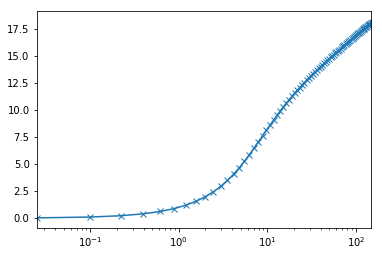

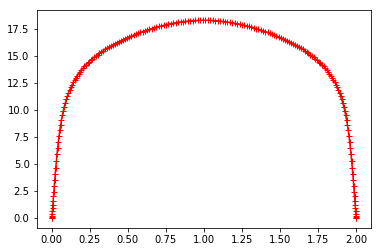

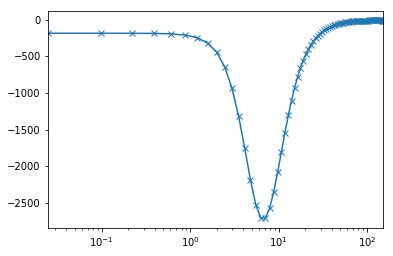

In [9]:
#d2Utest = miscUtil.DNSderivs(Utest)
plt.semilogx(186*zArr, UArr,'x-')
plt.xlim([0.,150.])
plt.show()

plt.figure()
plt.plot(zArr,UArr,'r+-')
plt.show()

plt.figure()
plt.semilogx(186*zArr, d2UArr[:],'x-')
plt.xlim([0.,150.])
#plt.ylim([-3000.,0.])
plt.show()

## Interpolating U using cubic splines

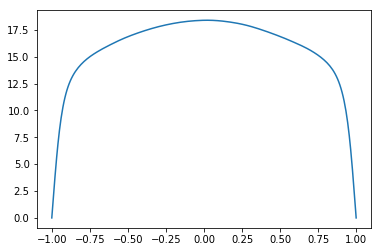

-8.995408584677733e-15 1.7208456881689926e-15


In [17]:
#zDNS = np.loadtxt(os.environ['DATA186']+'avg/zp.dat',dtype=np.float)
zDNS = np.zeros(194)
zDNS[1:-1] = miscUtil.nodesCellCenters(nCells=192)
zDNS[0] = 1.; zDNS[-1] = -1.
U = np.zeros(194)
Utmp = np.loadtxt(os.environ['DATA186']+'avg/u_avg_it150000.dat',dtype=np.float)
U[1:-1] = Utmp[3:-3]
plt.plot(zDNS,U); plt.show()
Ufun = interp1d(zDNS,U,kind='cubic')
print(Ufun(-1.), Ufun(1))

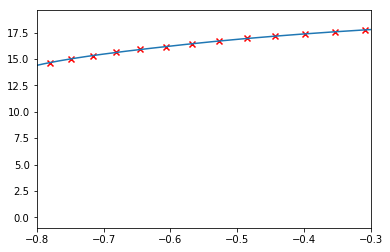

In [28]:
Unew2, z2 = miscUtil.interpDNS(Utmp[3:-3],nCheb=64)
plt.figure()
plt.plot(zDNS[3:-3],U[3:-3])
plt.scatter(z2, Unew2,marker='x',color='r')
plt.xlim([-0.8,-0.3])
plt.show()

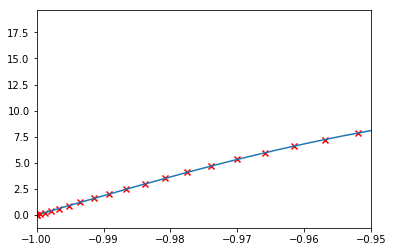

In [14]:
z1 = pseudo.chebdif(193,1)[0]
Unew = Ufun(z1)
plt.figure()
plt.plot(zDNS[3:-3],U[3:-3])
plt.scatter(z1, Unew,marker='x',color='r')
plt.xlim([-1.,-0.95])
plt.show()

In [15]:
Unew[[0,-1]]

array([  1.72084569e-15,  -8.99540858e-15])

## Test Scipy's interpolation

In [ ]:
x = np.linspace(-0.3,0.3,num=4)
y = x**3-x**2
splineFun1 = interp1d(x,y)
splineFun3 = interp1d(x,y,kind=3)
x1 = np.linspace(-0.2,0.2,num=3)
x3 = x1
y1 = splineFun1(x1)
y3 = splineFun3(x3)
xLong = np.linspace(-0.3,0.3,num=21)
yLong = xLong**3-xLong**2
plt.plot(xLong,yLong)
plt.scatter(x,y)
plt.scatter(x1,y1,color='r')
plt.scatter(x3,y3,color='k')
plt.show()

## Testing interp1d with DNS U

In [ ]:
# Using quartic spline, so 5 point stencil
zDNS = np.loadtxt(os.environ['DATA186']+'avg/zp.dat',dtype=np.float)
U = np.loadtxt(os.environ['DATA186']+'avg/u_avg_ref_it150500.dat',dtype=np.float)
zWall = zDNS[:14]
UWall = U[:14]
splineFun3 = interp1d(zWall,UWall,kind=3)
splineFun4 = interp1d(zWall,UWall,kind=4)
splineFun5 = interp1d(zWall,UWall,kind=5)
zNew = (zWall[:-1] + zWall[1:])/2.
Unew3 = splineFun3(zNew)
Unew4 = splineFun4(zNew)
Unew5 = splineFun5(zNew)
print(zWall)
print(UWall)

print(zNew)
print(Unew3)
print(Unew4)
print(Unew5)


plt.plot(zWall[1:],UWall[1:],'x-')
plt.scatter(zNew[1:10], Unew3[1:10],color='r')
plt.scatter(zNew[1:10], Unew4[1:10],color='k')
#plt.scatter(zNew[1:10], Unew5[1:10],color='g')
plt.legend(['DNS','Cubic interp','Quartic interp','Quintic interp'])
plt.ylim([0.,0.5])
plt.show()

## Linearity of U near the wall

In [ ]:
zDNS = np.loadtxt(os.environ['DATA186']+'avg/zp.dat',dtype=np.float)
U = np.loadtxt(os.environ['DATA186']+'avg/u_avg_ref_it150500.dat',dtype=np.float)
zPlusWall = 186.*zDNS[2:10]
UWall = U[2:10]

print(zPlusWall, UWall)
plt.plot(zPlusWall, UWall,'+-'); 
plt.xlim([0.,1.]); plt.ylim([0.,1.])
plt.show()


# Interpolation using cubic splines

In [ ]:
ztmp = np.loadtxt(os.environ['DATA186']+'avg/zp.dat',dtype=np.float)
Utmp = np.loadtxt(os.environ['DATA186']+'avg/u_avg_ref_it150500.dat',dtype=np.float)
UDNS = np.zeros(194)   # Including nodes at the walls
zDNS = np.zeros(194)
UDNS[1:-1] = Utmp[3:-3]
zDNS[1:-1] = ztmp[3:-3]
zDNS[-1] = 2.

Ufun = interp1d(zDNS,UDNS,kind='cubic')
z,D = pseudo.chebdif(194,1)
z = 1. - z[1:-1]
#z = 1.-z
D = D[1:-1,1:-1,0]
#D = D[:,:,0]

U = Ufun(z)




In [ ]:
plt.figure()
plt.plot(zDNS,UDNS)
plt.scatter(z,U)
plt.xlim([-0.01,0.02]); plt.ylim([-0.1,1.])
plt.show()
print(U[0],U[-1])

In [ ]:
plt.figure()
plt.plot(z, D@U/186.)
plt.xlim([0.,0.02]); plt.ylim([-1.1,-0.9])
plt.show()